In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from datetime import datetime, date, time, timedelta
from tqdm import tqdm, trange
from corr_utils import *

In [2]:
directory = './data/ground_truth/sdot/2022_01'
occ = pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if not filename.startswith('.') and os.path.isfile(f):
        df = pd.read_csv(f)
        occ = pd.concat([occ, df], ignore_index=True)
        
def convert_time(timestr):
    try:
        return datetime.strptime(timestr, '%I%p').time()
    except:
        return np.nan
    
def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%m/%d/%Y').date()
    except:
        return np.nan
        
occ = occ.drop(columns=['Unnamed: 0','Route','Label','Side of Street','Notes','Pictures'])
occ['Time'] = occ.apply(lambda r: convert_time(r['Time']), axis=1)
occ['Date'] = occ.apply(lambda r: convert_date(r['Date']), axis=1)
occ.dropna(subset=['Time','Date','Element Key'], inplace=True)
occ['Hour'] = occ.apply(lambda r: r['Time'].hour, axis=1)
occ['DateTime'] = occ.apply(lambda r: datetime.combine(r['Date'],r['Time']), axis=1)
occ['Occupancy'] = occ[['PAID','Load Zone','RPZ for that Block','ADA','Rideshare','ILLEGAL']].sum(axis=1)
occ['Element Key'] = occ.apply(lambda r: str(int(r['Element Key'])), axis=1)

In [3]:
occ.head()

,Time,Date,Element Key,Location,PAID,Load Zone,RPZ for that Block,ADA,Rideshare,ILLEGAL,...,Paid,RPZ,Rideshare Vehicle,Picture,Illegal,Complete,Unnamed: 8,Hour,DateTime,Occupancy
0,09:00:00,2021-10-22,1017,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2021-10-22 09:00:00,2.0
1,10:00:00,2021-10-22,1017,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,8.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,2021-10-22 10:00:00,8.0
2,11:00:00,2021-10-22,1017,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,9.0,2.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2021-10-22 11:00:00,11.0
3,12:00:00,2021-10-22,1017,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,11.0,2.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2021-10-22 12:00:00,13.0
4,13:00:00,2021-10-22,1017,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,9.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,2021-10-22 13:00:00,11.0


In [4]:
grouped = occ.groupby(['Element Key','Date'])

occ_dict = {}

for (ekey,date),group in tqdm(grouped):
    if occ_dict.get(ekey) == None:
        occ_dict[ekey] = {}
    occupancy = []
    for hr in timerange():
        count = group[group['Hour']==hr]['Occupancy'].sum()
        occupancy.append(count)
    occ_dict[ekey][date] = occupancy

100%|██████████████████████████████████████| 2507/2507 [00:04<00:00, 580.10it/s]


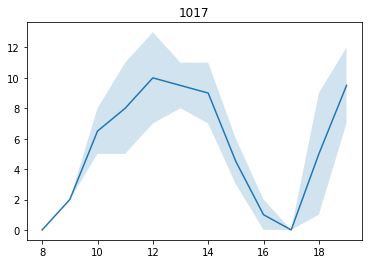

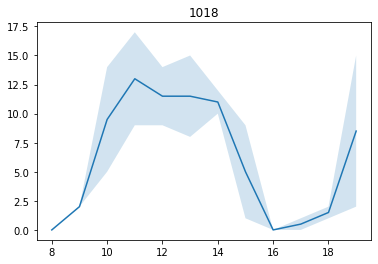

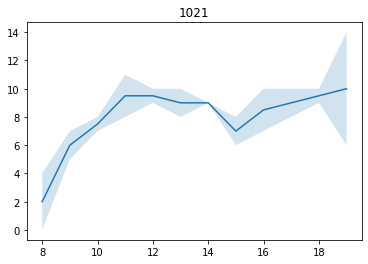

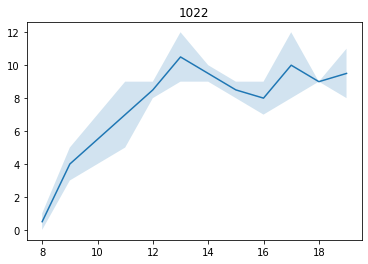

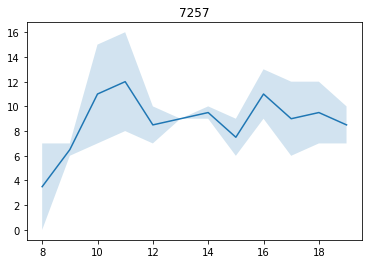

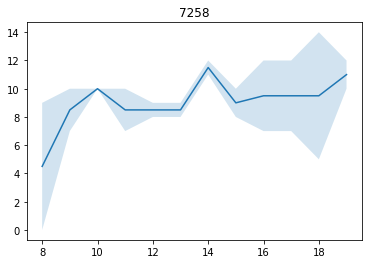

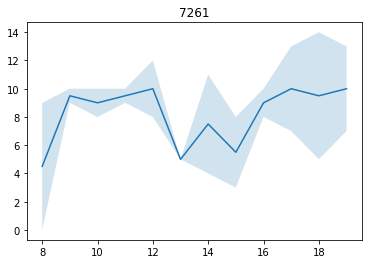

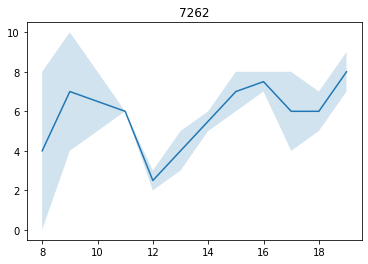

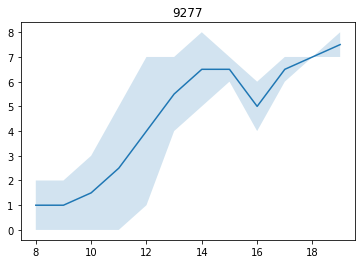

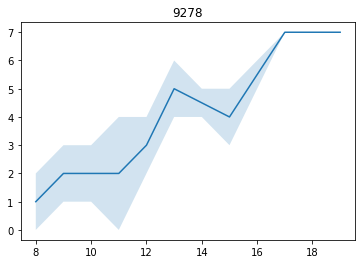

In [5]:
for ekey in occ['Element Key'].unique()[:10]:
    occupancy = []
    for date in occ_dict[ekey]:
        occupancy.append(occ_dict[ekey][date])
    occupancy = np.array(occupancy)
    occupancy = occupancy.reshape((-1,12))
    hours = [8+i for i in range(12)]
    plt.figure()
    plt.title(ekey)
    plt.plot(hours,np.mean(occupancy,axis=0))
    plt.fill_between(hours,
                     np.mean(occupancy,axis=0)-np.std(occupancy,axis=0),
                     np.mean(occupancy,axis=0)+np.std(occupancy,axis=0),
                     alpha=0.2)
    plt.show()

In [6]:
corr_dict = {}
for block_id_1 in tqdm(occ_dict):
    corr_dict[block_id_1] = {}
    for block_id_2 in occ_dict:
        b1_demand = []
        b2_demand = []
        for date in occ_dict[block_id_1]:
            b1_demand.extend(occ_dict[block_id_1][date])
            b2_demand.extend(occ_dict[block_id_2].get(date,[]))
        b1_demand = np.array(b1_demand)
        b2_demand = np.array(b2_demand)
        r,n = pearson_corr(b1_demand,b2_demand)
        r_U,r_L = corr_interval(r,n,0.05)
        corr_dict[block_id_1][block_id_2] = (r,r_U,r_L)

100%|██████████████████████████████████████| 1500/1500 [00:14<00:00, 105.00it/s]
